#Final Project

Context
You are a conservation biologist in charge of managing habitats for a protected
reserve. Your reserve includes several distinct patches of intact forest that harbor
populations of the endangered Warbling Babbler. You are worried about the longterm
fate of these populations if the habitats remain disconnected with limited
movement of individuals between them (i.e., limited migration between the
populations), so youʼd like to use funds from your budget to establish habitat
corridors that will allow individuals to move between the patches. However, you also
know that the populations have some phenotypic differences (like color) and you are
wondering how the frequencies of the phenotypes, and the overall population sizes,
will change in the populations once they are connected.


In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import random
import numpy as np

Your framework will include three types of classes: an Individual class, a Population class, and a Landscape class. Individuals exist in populations, and populations exist in a landscape. In each time step of your simulation, individuals can stay in the population where they started, or move to a
new population. The probabilities that individuals stay or leave are stored in a table called a dispersal matrix (more detail below).

In [2]:
class Individual:
    """Class to hold information on indiviuals."""# Add a docstring
        
    def __init__(self, id, phenotype):
        """The constructor for the individual class, with id and phenotype as attributes."""
        self.id = id
        self.phenotype = phenotype

In [8]:
testIndividual = Individual("LSU1", "purple")
print(testIndividual.phenotype)
print(testIndividual.id)


purple
LSU1
red


Population constructors should create a new list for individuals in that population,
and Populations should have methods to add and remove individuals, as well as to
calculate and print the frequency of phenotypes among individuals.

In [3]:
class Population:
    """Class to hold information on populations that is composed of individuals."""
    
    def __init__(self, id, popSize, phenotype): 
        """"The constructor for the population class."""
        self.id = id
        self.individuals = [] #create a list of individuals
        for i in range(popSize):
            self.individuals.append(Individual("%s-%d" % (id, i+1), phenotype)) #loop through the population (based on popSize) and add individuals to the individuals list, with       numbering for the id value starting at 1 (hence the i+1)

    def addIndividual(self, individual): #create method to add individuals to a list
        self.individuals.append(individual)
    
    def removeIndividual(self, individual): #create method to remove individuals from a list
        try:
            self.individuals.remove(individual) 
        except ValueError: #this fixes continuous errors that were occurring due to the remove function not working properly...it makes the function work despite errors
            pass
    
    def calculateFreq(self, phenotype): #calculates the frequency of the phenotypes found in a population
        freq = 0 #set the original frequency to zero to then calculate it later
        for ind in self.individuals: #loop through the list of individuals
             if ind.phenotype == phenotype: #if the phenotype in the list of individuals is equal to itself, then increase frequency by 1
                 freq = freq + 1
        return freq #save the value of the frequency for later use
    
    def printFreq(self, phenotype): #print out the phenotype and its frequency, also useful in testing of the code
        print("The %s phenotype frequency is %d" % (phenotype, self.calculateFreq(phenotype))) #this function calls the previous function of calculateFreq

In [5]:
testPopulation = Population("popA", 12, "purple")
for ind in testPopulation.individuals:
    print(ind.phenotype) 
testPopulation.printFreq("purple")

purple
purple
purple
purple
purple
purple
purple
purple
purple
purple
purple
purple
The purple phenotype frequency is 12


The dispersal matrix consists of
the probabilities that an individual disperses between populations, or stays in place,
each time step. For Warbling Babblers, these probabilities correspond to their
probability of moving in a week (Fig. 1). If an individual moves from one population
to another, you should remove it from the list of individuals in the population where
it started, and add it to the list of individuals in the population where it went. There
are multiple ways to use the probabilities in the dispersal matrix to decide if an
individual moves in each time step, but one function you may find helpful is
random.choices(…) from the random module.

Landscape constructors should create a new list for the populations in that landscape, and Landscapes should have a method that uses the probabilities in the dispersal matrix to determine if an individual moves or stays each time step. Either the Population or Landscape constructors should set the starting population sizes. The total number of individuals across all populations should stay constant, but individual populations may change size.

In [32]:
class Landscape:
    """Class to hold information on landscapes, which are composed of different populations, which in turn have different individuals."""
    
    def __init__(self, popSize=10, phenotypes=None, dispersalMatrix=None, simulationSteps=1): 
        """"The constructor for the Landscape class, taking population size, number of phenotypes, a dispersal matrix, and number of time steps as arguments."""
        self.dispersalMatrix = dispersalMatrix
        self.simulationSteps = simulationSteps
        self.phenotypes = phenotypes
        self.popSizeRecords = [[]] #[[10,10,10],[11,9,10]...]
        self.phenoFreqRecords = [[]] #[[[10,0,0],[0,10,0],[0,0,10]],[...]]
        self.populations = [] #creates a list of populations
        self.popAlias = []
        for i in range(len(phenotypes)): #iterate through the populations (initially determined by the number of phenotypes since one phenotype per population)
            self.populations.append(Population('pop%s' % chr(65 + i), popSize, phenotypes[i])) #append each population to the list of populations, numbering based on alphabet, A is chr 65
            self.popAlias.append('pop%s' % chr(65 + i)) #create a new list with alias for each population, listing only the population id so that info about popluations can be added to it and used later to determine how to move b/n pops
            self.popSizeRecords[0].append(popSize)
            popPhenoFreq = [0] * len(phenotypes)
            popPhenoFreq[i] = popSize
            self.phenoFreqRecords[0].append(popPhenoFreq)
    
    def migratePop(self): #function to move from one population to another
        migrationRecords = {} #create a dictionary to retain info about the migration

        for i in range(len(self.populations)): #loop through the list of populations
            popSize = len(self.populations[i].individuals)  #the population size is equal to the length of the list
            probWeights = self.dispersalMatrix[i] #this sets the probability whether an individual moves and need to put a dispersal matrix as an input
            migrationMap = random.choices(self.popAlias, weights=probWeights, k=popSize) #this randomly selects the destination population from the population Alias list, using the weights for the seleciton from the dispersal matrix, and does it for each individual, determined by popsize 
            #e.g. output for migrationMap => [popA,popB,popA,popA,popC,popA,popA,popC,popB,popA]
            sourcePopId = self.populations[i].id #this makes a list for the source population
            for indIndex, destPop in enumerate(migrationMap): #assigns a counter for the migrationMap list
                if destPop != self.populations[i].id: #if the value of destpop does not equal the population id then...
                    
                    migrant = self.populations[i].individuals[indIndex] #identify the individual as a migrant
                    destPopIndex = self.popAlias.index(destPop) #find the destination population's index using index function to use in the upcoming if, else statement

                    if sourcePopId in migrationRecords:
                        migrationRecords[sourcePopId].append({'migrant': migrant, 'destPopIndex': destPopIndex, 'sourcePopIndex': i}) #if the source population is in the migration Record dictionary, then append it to the dictionary, otherwise, create a new occurance in the dictionary
                    else:
                        migrationRecords[sourcePopId] = [{'migrant': migrant, 'destPopIndex': destPopIndex, 'sourcePopIndex': i}]
                
        for pop in migrationRecords: #loop through each of the populations in the dictionary
            for record in migrationRecords[pop]: #for each of the populations, then loop through each of the records, i.e. sourcePopIndex, destPopIndex, migrant
                sourcePopIndex = record['sourcePopIndex']
                destPopIndex = record['destPopIndex']
                migrant = record['migrant']
                self.populations[destPopIndex].addIndividual(migrant) #use the add individual function to add the migrant to the destination population from the original self.populations
                self.populations[sourcePopIndex].removeIndividual(migrant) #use the remove individual function to remove the migrant from the source population from the original self.populations
        self.storePopSize()
        self.storePhenoFreq()
           
    def startSimulation(self): #a function to call how many time steps the simulation should be run for
        for i in range(self.simulationSteps):
            print('Simulating step %d...' % (i+1))
            self.migratePop()
        print('Simulation complete.')

    def storePopSize(self):
        popSizeRecords = []
        for pop in self.populations:
            popSizeRecords.append(len(pop.individuals)) #temporarily store population sizes in a list  
        self.popSizeRecords.append(popSizeRecords) #store population sizes in the landscape attribute for each migration stage    

    def storePhenoFreq(self):
        phenoFreqRecords = []
        for pop in self.populations:
            for phenoIndex, pheno in enumerate(self.phenotypes):
                if phenoIndex < len(phenoFreqRecords):
                    phenoFreqRecords[phenoIndex].append(pop.calculateFreq(pheno))
                else:
                    phenoFreqRecords.append([pop.calculateFreq(pheno)])
        self.phenoFreqRecords.append(phenoFreqRecords)

    def printLandscapeStatus(self):
        print('\nFinal landscape status:')
        for pop in self.populations:
            print('Population: %s' % pop.id)
            for ind in pop.individuals:
                print('%s => %s' % (ind.id, ind.phenotype))

    def plotPopSummary(self):
        labels = self.phenotypes
        for pop in self.populations:
            popSummary = []
            # Setting up the plot
            plt.title("Phenotype Distribution for %s" % pop.id) 
            for pheno in self.phenotypes:
                popSummary.append(pop.calculateFreq(pheno))

            plt.pie(popSummary, labels=labels, autopct=lambda p : '{:.1f}%({:,.0f})'.format(p,p * sum(popSummary)/100), shadow=True, startangle=140)
            plt.axis('equal')
            plt.show()


    def plotPhenoFreq(self):
        # Generating frequency data
        xValues = list(range(0, self.simulationSteps + 1))
        transPhenoFreqRecords = np.array(self.phenoFreqRecords).T.tolist() #with transposing it considers per population, then group by phenotype

        for phenoIndex, pheno in enumerate(self.phenotypes):
            # Setting up the plot
            plt.title("Phenotype '%s' Frequency Changes" % pheno) #use the state of choice as the plot title
            plt.ylabel("Population (individuals)") #use the count of choice (i.e. deaths or cases) to label the y axis
            plt.xlabel("Simulation Step")

            for popIndex, pop in enumerate(transPhenoFreqRecords):
                yValues = pop[phenoIndex]
                plt.plot(xValues, yValues, marker="o", label=self.popAlias[popIndex])  #line plot using the xaxis and yaxis from above

            plt.locator_params(axis="both", integer=True, tight=True)
            plt.margins(0.05)
            plt.legend()
            plt.show()    

    def plotPopSizes(self):
        # Generating pop size data
        xValues = list(range(0, self.simulationSteps + 1))
        transPopSizeRecords = np.array(self.popSizeRecords).T.tolist()

        # Setting up the plot
        plt.title("Population Size Changes") #use the state of choice as the plot title
        plt.ylabel("Population (individuals)") #use the count of choice (i.e. deaths or cases) to label the y axis
        plt.xlabel("Simulation Step")

        for popIndex, yValues in enumerate(transPopSizeRecords):
            plt.plot(xValues, yValues, marker="o", label=self.popAlias[popIndex])  #line plot using the xaxis and yaxis from above
        
        plt.locator_params(axis="both", integer=True, tight=True)
        plt.margins(0.05)
        plt.legend()
        plt.show()


Simulating step 1...
Simulating step 2...
Simulating step 3...
Simulating step 4...
Simulating step 5...
Simulating step 6...
Simulating step 7...
Simulating step 8...
Simulating step 9...
Simulating step 10...
Simulation complete.


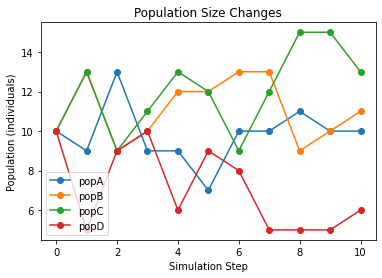

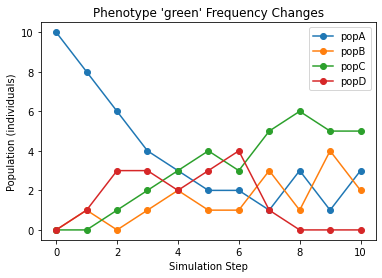

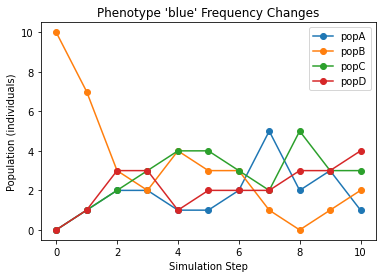

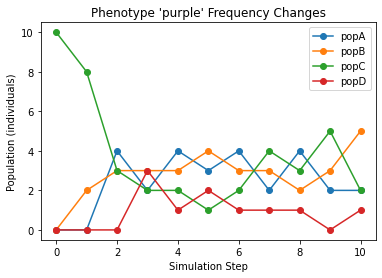

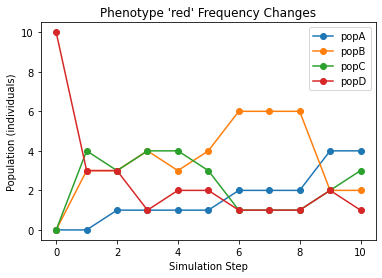

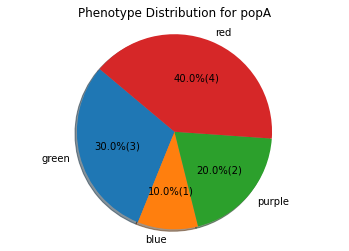

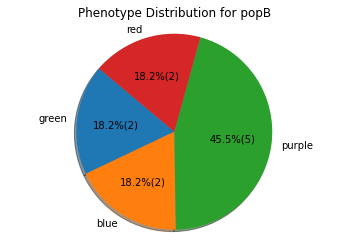

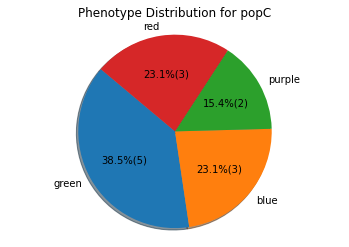

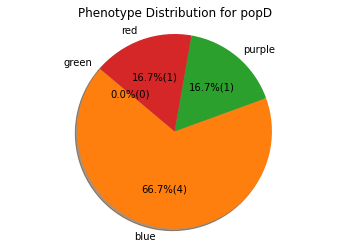

In [33]:
phenotypes = ['green', 'blue', 'purple', 'red']
dispersalMatrix = [
    [0.6, 0.1, 0.2, 0.1],
    [0.2, 0.6, 0.1, 0.1],
    [0.1, 0.2, 0.6, 0.1],
    [0.1, 0.1, 0.3, 0.5]]
steps = 10
popSize = 10

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps)
testLandscape.startSimulation()
#plotting:
testLandscape.plotPopSizes()
testLandscape.plotPhenoFreq()
testLandscape.plotPopSummary()